# Project Group - 15
Members: 

         Guoheng Li 5939259

         Junpeng Li 5921856

         Haosen Luo 5936195
         
         Chenwei Peng 591838


# Research Objective

## Objective

Based on its importance, a variety of car following models are put forward trying to model such phenomenon. However, different models are based on different assumptions, formulations and methodologies, which entails real-world data to test their limitations and advantages, for instance, some of them can't account for some specific car following patterns. Nowadays, with preprocessed real-world car following data, we are able to calibrate the car following phenomana better and more precisely.
Therefore, in this project the objectives are:

**用提问的方式表达**
1. Can we extract some correlations among some car following variables, for instance the headway, follower's velocity and acceleration? Based on these correlations, in what way are the IDM and Gipps models formulated?

2. How can we implement these models in Python, and how can we calibrate the hyperparameters? Are there some pros and cons between these two models? How can we possibly further improve these two models?


# Contribution Statement

Work in Process

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Author 1**: Guoheng Li

**Author 2**: Junpeng Li

**Author 3**: Chenwei Peng

**Author 4**: Haosen Luo


# 1. Introduction

Researching car following models is critical in transportation engineering and urban planning. These models provide insights essential for congestion management, infrastructure planning, environmental impact assessment, and safety improvement. By understanding traffic dynamics, decision-makers can optimize traffic flow, identify congestion-prone areas, and design efficient road networks. This leads to reduced emissions, energy conservation, and increased road safety. Traffic flow models also aid in public transportation optimization, enhancing services for commuters. They support data-driven decision-making and offer economic benefits by improving productivity and reducing fuel consumption. In essence, traffic flow models are invaluable tools that inform decisions, ultimately shaping sustainable urban development and improving overall quality of life.

# 2. Data

## 2.1 Data Used

In this project, we used car-following datasets provided in [this paper](https://arxiv.org/pdf/2305.18921.pdf), which is originally collected by autonomous vehicles (AVs) from the open Lyft level-5 dataset to study car-following behavior in mixed traffic flow. The dataset consisted of over 29,000 HV-following-AV (H-A) and 42,000 HV-following-HV (H-H) car-following segments. The dataset includes over 1000 hours of perception and motion data collected over a 4-month period from urban and suburban environments along a fixed route in Palo Alto, California. The dataset comprises approximately 170,000 scenes, with each scene spanning approximately 25 seconds. Each scene includes the movement states of perceived vehicles, cyclists, and pedestrians, as well as the position and orientation of the autonomous vehicle (AV). 

Then, data is processed using a data processing framework that involved several steps. First, CF pairs and their raw trajectories were selected from the unlabelled dataset based on certain rules. Then, the raw data quality was assessed through anomaly analysis. The next step involved enhancing the raw data. For AVs, missing segments were filled and smooth position and speed were estimated. For HVs, missing data around 0-speed points was filled using a jerk-minimization method. Finally, vehicle size processing was performed to split the enhanced dataset into two groups: H-A and H-H.

The result of data processing was an enhanced dataset that had higher quality and covered diverse regimes for calibrating car-following models. The enhanced data showed a reduction in anomalies, particularly in abnormal jerk sign inversion. This processed dataset can be further used for investigating car-following behavior in mixed urban traffic and the impact of AVs on traffic.

With diverse algorithms, we have obtained the data of the regime of each vehicle from an enhanced dataset. In the dataset of regime of each vehicle pairs, we have considered 7 regimes: 
  1. free acceleration (Fa)
  2. free deceleration not caused by the leading vehicle (Fd)
  3. cruising at a desired speed (C)
  4. acceleration following a leading vehicle (A)
  5. deceleration following a leading vehicle (D)
  6. constant speed following (F)
  7. standstill (S)

The dataset also provides the time duration of each regime as well as the combination for each car-following case id which is for further analysis.

**All the steps above are already done before dataset published, thus how to impletement these process is out of scope of our project, our project focuses on visualization, modelling and calibration on car following models, using the processed data**


## 2.2 Data Preprocessing Pipeline

### 2.2.1 data processing
We will clean the data, reduce data noise, and improve the quality of the data, making it more suitable for subsequent analysis or modeling tasks.

### 2.2.2 Data sorting
We will classify the following 7 modes based on size, centroid, acceleration and velocity: free acceleration (Fa), free deceleration not caused by the leading vehicle (Fd), cruising at a desired speed (C), acceleration following a leading vehicle (A), deceleration following a leading vehicle (D), constant speed following (F), and standstill (S).

## 3 Pipeline

### 3.2.1 data exploration and plotting
In order to explore the relations between the given car following dataset and the common car following models, and to derive some inspirations on how these models are developed, we resort to data exploration methods to help analyzing. 

Here are several ways to perform calculations on data：
- Headspace：The distance between the heading of the front car and the rear car.
- Vehicle distance: The distance from the rear bumper of the front vehicle to the front of the rear vehicle.
- Effect of size on distance：Effect of vehicle size on distance between vehicles.
- Statistics: Variance / mean.
- Analyze different regimes: Relationships between vehicle attributes.
By analylising these 

### 3.2.2 Modelling
We will apply the Intelligent Driver Model and Gipps Model to verify their applications on different regimes, and try analysing their behaviour patterns as well pros and cons. However, to do so there are some parameters left to be filled in. Therefore, we have to calibrate the parameters first objectively and comprehensively, i.e. we decided to calibrate the parameters by using algorithms to minimize the total car following trajectory loss, and apply them to different regimes due to the huge discrepancy among various patterns.


![IMAGE](./images/image.png)

# 4. Data Exploration

In [3]:
# import dependent libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 4.1 对数据进行描述

### 4.1.1 相关系数图
最intuitive的想法（不用分类）

1. v和车头间距的关系 / a和车头间距的关系
2. ...balabala

### 4.1.2 直方图

1. 速度，加速度，车头间距做频率分布直方图分析（对不同的regimes）

- 为什么会出现那么多0?

2. 车辆size的直方图

### 4.1.3 饼图

1. HH HA 分开探讨 不同regimes下的数量占比

## 4.2 数据关系分析

1. 为什么要划分ADF....这些模式： 通过直方图来反映各个量看看有没有区别

2. IDM模型需要至少ADF的数据，那么IDM模型是怎么构建的，参数之间有什么关系（可以直接用ADF数据）:
    - 车头间距和加速度的关系
    - 速度和理想速度的比值（？）（分场景ADF+1 / ADF / ADF+2）的差距会对加速度有什么影响

# 5. Models, Calibrations & Pros and Cons

While there are many available models for car following, different kinds of models account for different behaviours. Based on the data exploration and the conclusion we made in the last part:
- 1
- 2
- 3

In recent studies, common car following models we are to discuss, are usually devided into 3 types.

## 5.1 Models

### 5.1.1 Desired Measures Models (Intelligent Driver Model)

The model presumes that each driver has a desired velocity, headway, and the drivers try to minimize the gap between the actual value and the desired value, while constrained by a variety of conditions, for instance safety distances. Intelligent Driver Model(IDM) is catagorized in this catagorization:

Drivers try to minimize the following distance, and minimize both the speed difference and desired headway as well. In IDM model:

1. The influence factors include own speed $v$, the bumper-to-bumper gap $s$ to the lead vehicle, and the difference of the speed $\Delta v = v - v_{\text{lead}}$

2. The model only outputs the acceleration $a$ on the following car.

3. The model parameters are driving styles.


The IDM model equations are fomulated as follows:
$$
\begin{aligned}
&\frac{dv}{dt} = a\left[1 - \left(\frac{v}{v_0}\right)^\sigma - \left(\frac{s^*(v, \Delta v)}{s}\right)^2 \right]\\

&s^*(v, \Delta v) = s_0 + \max\left[0, \left(vT+\frac{v\Delta v}{2 \sqrt{ab}}\right)\right]
\end{aligned}
$$

In [4]:
class Car:
    
    def __init__(self, size: float, xs: np.array = [], vs: np.array = [], a_s: np.array = []) -> None:
        self.vs = vs
        self.xs = xs
        self.a_s = a_s
        self.size = size

In [7]:
## IDM models with arbitary parameters

class IDM:
    
    def __init__(self, param: dict) -> None:
        ## dict = {v0, s0, T, a, b}
        self.v0 = param['v0']  # the velocity the vehicle would drive at in free traffic
        self.s0 = param['s0'] # a minimum desired net distance.
        self.T = param['T'] # the minimum possible time to the vehicle in front
        self.a = param['a'] # the maximum vehicle acceleration
        self.b = param['b'] # a positive number (comfortable breaking deceleration)
        self.sigma = 4 # exponent factor, usually set to 4

    def get_desired_s(self, v_this, delta_v_i):
        
        desired_s = v_this * self.T + v_this * delta_v_i / (2 * np.sqrt(self.a * self.b))
        return self.s0 + max(0, desired_s)
    
    def get_new_a(self, v_this, v_front, s_this):
        
        delta_v_i = v_this - v_front
        return self.a * (1 - np.power(v_this / self.v0, self.sigma) 
                            - np.power((self.get_desired_s(v_this, delta_v_i) / s_this), 2))
    
    def update(self, lead_car: Car, this_car: Car, time_step: float):
        """
            
        """
        assert this_car is not None
        
        N = len(lead_car.xs)
        
        for i in range(1, N):
            this_v_now = this_car.vs[i - 1]
            lead_v_now = lead_car.vs[i - 1]
            this_s_now = this_car.xs[i - 1]
            lead_s_now = lead_car.xs[i - 1]
            
            gap_now = lead_s_now - this_s_now - lead_car.size  # the distance is head's distance
            this_v_a = self.get_new_a(this_v_now, lead_v_now, gap_now)
            # update
            if this_v_now + this_v_a * time_step < 0:
                this_car.vs.append(0)
            else:
                this_car.vs.append(this_car.vs[i - 1] + time_step * this_v_a)
            this_car.xs.append(this_car.xs[i - 1] + this_car.vs[i - 1] * time_step + 1 / 2 * this_v_a * pow(time_step, 2))
            this_car.a_s.append(this_v_a)

### 5.1.2 Gipps Model

In [18]:
## Gipps model

class Gipps:
    
    def __init__(self, param) -> None:
        self.rect_time = param["rect_time"]
        self.max_b = param["max_b"]
        self.max_a = param["max_a"]


    def update(self, lead_car: Car, this_car: Car, time_step: float):

        N = len(lead_car.xs)
        this_car.a_s = None  # Gipps model doesn't need a for estimating
        
        for i in range(1, N):
            
            this_v_now = this_car.vs[i - 1]
            lead_v_now = lead_car.vs[i - 1]
            this_s_now = this_car.xs[i - 1]
            lead_s_now = lead_car.xs[i - 1]

            this_v = - self.max_b * self.rect_time + np.sqrt(pow(self.max_b, 2) * pow(self.rect_time, 2) + self.max_b * (2*(lead_s_now - this_s_now - lead_car.size)- self.rect_time * this_v_now + pow(lead_v_now, 2)/self.max_b))

            this_car.vs.append(this_v)
            this_car.xs.append(this_car.xs[i - 1] + this_car.vs[i - 1] * time_step)

        

TOTAL TIME STEP: 220
[-25.26, -24.103, -23.20675163551545, -22.303793489349555, -21.394766756546954, -20.481691906253506, -19.567004168692087, -18.65091621941771, -17.734085174364974, -16.815482333259965, -15.892858682329654, -14.965485772179083, -14.03327775385833, -13.097380674164814, -12.157638245275162, -11.214385210796749, -10.267543577893136, -9.31917839077062, -8.368110211667474, -7.413638790023444, -6.456244910154043, -5.495638196001993, -4.5328473265580795, -3.568160861504268, -2.602055780282545, -1.6347568022172925, -0.6664833908408485, 0.3027159629211492, 1.271217505549198, 2.2410572452000164, 3.2120180308846042, 4.184067080468969, 5.157029723798544, 6.128903140312714, 7.1021098686695145, 8.077805002680316, 9.055158825051269, 10.033754744441264, 11.013175565408911, 11.993027504360661, 12.973126960210713, 13.954108802160691, 14.934216467024342, 15.914734150025977, 16.89691790747811, 17.880649944537062, 18.865976722797786, 19.85274881585841, 20.837702984280423, 21.819972948932

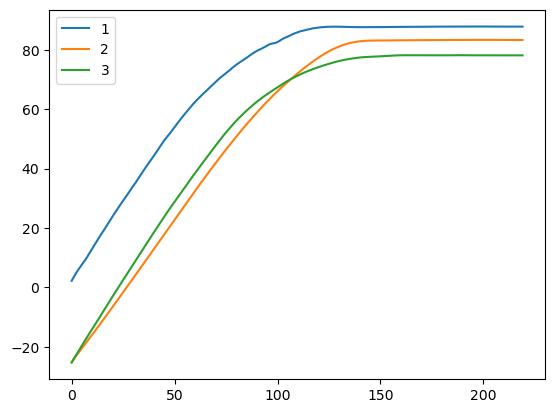

In [17]:

CARS = np.loadtxt("D:\DATA\TIL6022\data.csv", delimiter=",")
test_scenes = []
for i in range(1000):
    test_scenes.append(np.squeeze(CARS[np.where(CARS[:, 0] == i), :], 0))


test_scene = test_scenes[31]

print("TOTAL TIME STEP: %d" %test_scene.shape[0] )


car_front = Car(4.5, test_scene[:, 1] + 2.25, test_scene[:, 3], test_scene[:, 3])

car_follow = Car(5, [test_scene[0, 4] + 2.5], [test_scene[0, 5]], [test_scene[0, 6]])

car_follow_real = Car(5, [test_scene[:, 4] + 2.5], [test_scene[:, 5]], [test_scene[:, 6]])

param = {
    "rect_time": 0.2,
    "max_b": 2,
    "max_a": 2
}

gipps = Gipps(param)

gipps.update(car_front, car_follow, 0.1)

print(car_follow.xs)
print(car_front.xs)
print(car_follow_real.xs)


plt.plot(car_front.xs, label="1")
plt.plot(car_follow.xs, label="2")
plt.plot(car_follow_real.xs[0], label="3")
plt.legend()
plt.show()

## 

## 5.2 Calibration



In [ ]:
from sko.GA import GA
import src.Genetic as Ge

NUM_TEST = 100
FILE_DIR = "D:\DATA\TIL6022\data.csv"

CARS = np.loadtxt(FILE_DIR, delimiter=",")
test_scenes = []
for i in range(NUM_TEST):
    test_scenes.append(np.squeeze(CARS[np.where(CARS[:, 0] == i), :], 0))


ga = GA(func=Ge.fitness, n_dim=5, size_pop=50, max_iter=20, prob_mut=0.01, lb=[5, 10, 30, 1, 10], ub=[40, 400, 200, 600, 600], precision=1)
result = ga.run()
print(result)

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(2, 1)
ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.show()

# 6. Limitations and further research

# References

1. [Large Car-following Data Based on Lyft level-5 Open Dataset: Following Autonomous Vehicles vs. Human-driven Vehicles. Guopeng Li, Yiru Jiao, Victor L. Knoop, Simeon C. Calvert, and J.W.C. van Lint](https://arxiv.org/pdf/2305.18921.pdf)
